In [ ]:
pip install neuralforecast

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from neuralforecast.core import NeuralForecast
from neuralforecast.models import NHITS, NBEATS, TimesNet

from neuralforecast.losses.numpy import mae, mse

In [3]:
plt.rcParams["figure.figsize"] = (9,6)

## Read data

In [4]:
df = pd.read_csv('/content/data.csv')

df['ds'] = pd.to_datetime(df['ds'])

df.head()

,ds,unique_id,y
0,2016-07-01 00:00:00,OT,1.460552
1,2016-07-01 01:00:00,OT,1.161527
2,2016-07-01 02:00:00,OT,1.161527
3,2016-07-01 03:00:00,OT,0.862611
4,2016-07-01 04:00:00,OT,0.525227


In the figure above, note that the dataset already has the format expected by NeuralForecast. Basically, the package requires three columns:

* a date column labelled as *ds*
* an id column to label your series, labelled as *unique_id*
* a value column labelled as *y*


Then, we can plot our series:

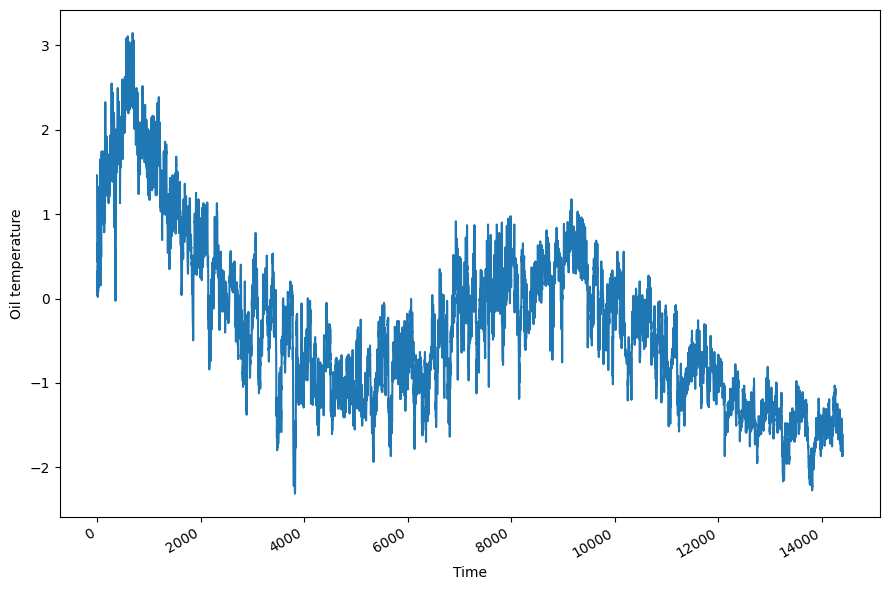

In [5]:
fig, ax = plt.subplots()

ax.plot(df['y'])
ax.set_xlabel('Time')
ax.set_ylabel('Oil temperature')

fig.autofmt_xdate()
plt.tight_layout()

###Forecasting

Here we use a forecasting horizon of 96 hours, which is a common horizon for long-term forecasting in the literature.

We also reserve two windows of 96 time steps to evaluate our models.

First, we define a list of models that we want to use to carry out the forecasting task. Again, we will use N-BEATS, N-HiTS, and TimesNet.

We will keep the default parameters for all models, and limit the maximum number of epochs to 50.

*Note that by default, TimesNet will select the top 5 most important periods in our data.*

In [6]:
horizon = 96

models = [NHITS(h=horizon,
               input_size=2*horizon,
               max_steps=50),
         NBEATS(h=horizon,
               input_size=2*horizon,
               max_steps=50),
         TimesNet(h=horizon,
                 input_size=2*horizon,
                 max_steps=50)]

INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1


Once this is done, we can instantiate the NeuralForecasts object with the list of our models and the frequency of our data, which is hourly.

In [7]:
nf = NeuralForecast(models=models, freq='H')

Then, we run cross-validation so that we have the predictions and the actual values of our dataset. That way, we can evaluate the performance of each model.

Again, we use two windows of 96 time steps for the evaluation.

In [8]:
preds_df = nf.cross_validation(df=df, step_size=horizon, n_windows=2)

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

In [9]:
preds_df.head()

,unique_id,ds,cutoff,NHITS,NBEATS,TimesNet,y
0,OT,2018-02-13 00:00:00,2018-02-12 23:00:00,-1.410102,-1.406131,-1.511359,-1.398929
1,OT,2018-02-13 01:00:00,2018-02-12 23:00:00,-1.420130,-1.388881,-1.541108,-1.398929
2,OT,2018-02-13 02:00:00,2018-02-12 23:00:00,-1.433461,-1.432182,-1.513930,-1.421923
3,OT,2018-02-13 03:00:00,2018-02-12 23:00:00,-1.444783,-1.461710,-1.533674,-1.506269
4,OT,2018-02-13 04:00:00,2018-02-12 23:00:00,-1.462783,-1.454613,-1.506913,-1.452545


Once the models are trained and predictions are done, we get the DataFrame above. We can see the actual values, as well as the predictions coming from each model that we specified earlier.

We can also easily visualize the predictions against the actual values.

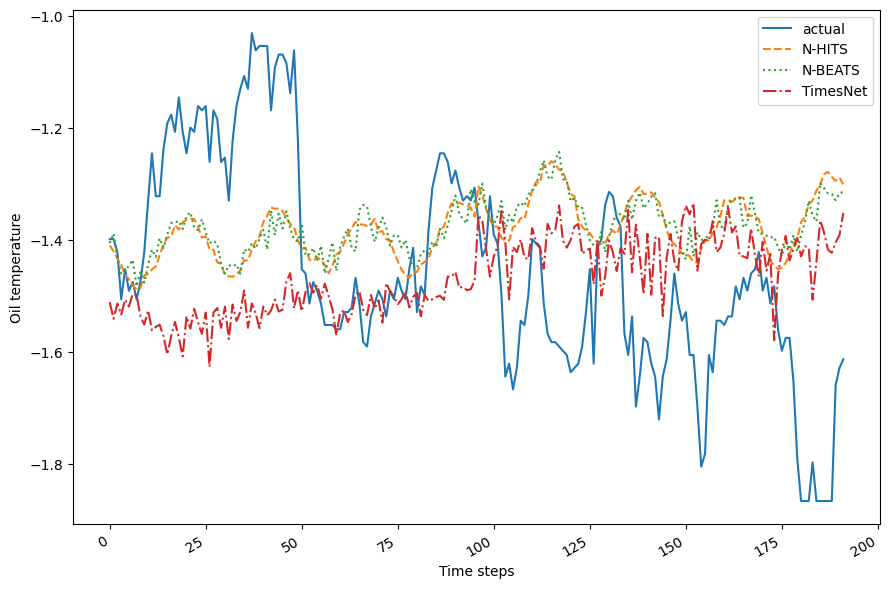

In [10]:
fig, ax = plt.subplots()

ax.plot(preds_df['y'], label='actual')
ax.plot(preds_df['NHITS'], label='N-HITS', ls='--')
ax.plot(preds_df['NBEATS'], label='N-BEATS', ls=':')
ax.plot(preds_df['TimesNet'], label='TimesNet', ls='-.')

ax.legend(loc='best')
ax.set_xlabel('Time steps')
ax.set_ylabel('Oil temperature')

fig.autofmt_xdate()
plt.tight_layout()

In the figure above, it seems that all models fail to predict the decrease in oil temperature observed in the test set. Also, N-BEATS and N-HiTS have captured some cyclical pattern that is not observed in the predictions of TimesNet.

Still, we need to evaluate the models by calculating the MSE and MAE to determine which model is best.

### Evaluation
Now, we simply compute the MAE and MSE to find out which model performed best.

In [11]:
data = {'N-HiTS': [mae(preds_df['NHITS'], preds_df['y']), mse(preds_df['NHITS'], preds_df['y'])],
       'N-BEATS': [mae(preds_df['NBEATS'], preds_df['y']), mse(preds_df['NBEATS'], preds_df['y'])],
       'TimesNet': [mae(preds_df['TimesNet'], preds_df['y']), mse(preds_df['TimesNet'], preds_df['y'])]}

metrics_df = pd.DataFrame(data=data)
metrics_df.index = ['mae', 'mse']

metrics_df.style.highlight_min(color='lightgreen', axis=1)

,N-HiTS,N-BEATS,TimesNet
mae,0.180567,0.183694,0.186492
mse,0.049619,0.049481,0.055724


From the figure above, we can see the N-HiTS achives the lowest MAE, while N-BEATS achieves the lowest MSE.

However, there is a difference of 0.002 in MAE, and a difference of 0.00025 in MSE. Since the difference in MSE is so small, especially considering the error is squared, I would argue that N-HiTS is the champion model for this task.

So, it turns out that TimesNet did not achieve the best performance. However, keep in mind that we just conducted a simple experiment with no hyperparameter optimization, on one dataset only, and on two windows of 96 time steps.

This is really meant to show you how to work with TimesNet and NeuralForecast, so that you can have another tool in your toolbox to solve your next forecasting problem.